In [1]:
from operator import add
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from pyspark import SparkContext, SparkConf

import numpy as np
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(threshold=10000,
                    linewidth=100,
                    formatter={'float_kind':float_formatter})

output_dir = "new_recent"

In [2]:
# load up spark
conf = (SparkConf().setMaster("local[*]").setAppName("My app"))
sc = SparkContext(conf=conf)

In [5]:
import os
from vaderSentiment.vaderSentiment import sentiment
def get_sentiment_for_line(line):
    uid, identities, text = line.strip().split("\t")
    identities = identities.split(",")
    sent = sentiment(text,alpha_normalizer=15.)['compound']
    for identity in identities:
        yield ((uid, identity), sent)

raw_text = sc.textFile(os.path.join(output_dir,"training_raw_text_fin.txt"),600)
sent_per_uid_identity = (raw_text.flatMap(get_sentiment_for_line)
                         .aggregateByKey((0,0), lambda a,b: (a[0] + b,    a[1] + 1),
                                                 lambda a,b: (a[0] + b[0], a[1] + b[1]))
                          .mapValues(lambda v: float(v[0])/float(v[1])).collect())

In [6]:
sc.stop()

In [7]:
import pandas as pd
df = pd.DataFrame([ [x[0],x[1], y] for x, y in sent_per_uid_identity])
df.columns = ['uid','iden_id','val']
df.to_csv(os.path.join(output_dir,"user_to_identity_to_simple_sent_val.csv"))

In [9]:
import numpy as np
index_to_identity = {int(line.split("\t")[0]) : line.strip().split("\t")[1] 
               for line in open(os.path.join(output_dir,"index_to_identity_final.tsv")) }

from constraints import IDENTITY_PREFIX
identities = [x.strip() for x in open("../data/identity_data/final_identities_list.txt").readlines()]

identity_to_id = pd.DataFrame([(identity,IDENTITY_PREFIX+str(i)) for i, identity in enumerate(identities)], 
                              columns=['identity','iden_id'])

In [10]:
res = df[['iden_id','val']].groupby("iden_id").mean().reset_index()
res.columns = ['iden_id','mean_val']
res = pd.merge(res, identity_to_id,on='iden_id')

In [11]:
import pandas as pd
import msgpack
import seaborn as sns
sns.set()
%matplotlib inline

In [13]:
sent_model_info = msgpack.load(open("new_recent/sent_res_final/-1_sent_basic.mpack"))
x = np.load(open("new_recent/sent_res_final/899_mu.npy"))
my_res = pd.DataFrame([(sent_model_info['index_to_ids'][i][:-1], z) 
                       for i,z in enumerate(x) if sent_model_info['index_to_ids'][i].endswith('e')],
                      columns=['iden_id','my_res'])

/home/kjoseph/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


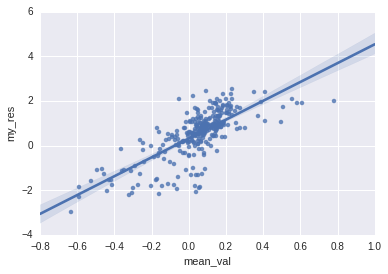

In [14]:
d = pd.merge(res,my_res)

sns.regplot('mean_val','my_res',d)

In [15]:
from sklearn.preprocessing import scale
d['diffv'] = abs(scale(d.mean_val) - scale(d.my_res))

In [16]:
d[d.identity=='thot']

,iden_id,mean_val,identity,my_res,diffv
59,i_151,-0.01297,thot,-1.104259,1.219374


In [18]:
d['scale_vader'] = scale(d.mean_val)
d['scale_my'] = scale(d.my_res)
d.sort('diffv',ascending=False)

,iden_id,mean_val,identity,my_res,diffv,scale_vader,scale_my
199,i_278,0.783360,best friend,1.982362,2.641081,4.046819,1.405737
278,i_70,0.038636,pimp,-2.081126,2.443065,-0.058146,-2.501211
308,i_98,0.057064,gangster,-1.910965,2.381034,0.043429,-2.337605
162,i_244,0.058594,alcoholic,-1.844239,2.325311,0.051861,-2.273450
207,i_285,0.035904,addict,-1.817013,2.174066,-0.073206,-2.247273
83,i_173,-0.054267,firefighter,2.089420,2.078906,-0.570236,1.508670
153,i_236,0.498692,friend,1.050891,1.967561,2.477710,0.510149
187,i_267,0.069151,goon,-1.289271,1.849917,0.110056,-1.739862
120,i_206,0.609556,champion,1.890246,1.771634,3.088803,1.317169
10,i_107,0.048815,homeless,-1.302536,1.750575,-0.002040,-1.752615


In [ ]:
sns.distplot(d.mean_val)

In [ ]:
sns.distplot(d.my_res)

In [ ]:
sns.distplot(d.diffv)